## 1.Expectation Maximization for GMM

In [498]:
# Sample from GMM 0.5 * N(5,1) + 0.5 * N(-5, 1)
import numpy as np
m1, m2, s1, s2 = 5, -5, 1, 1
w = 0.5
n = 500

In [499]:
def GMM_sample(nsamples, m1, s1, m2, s2, w):
    toss = np.random.rand(nsamples)
    
    sd = s1*np.ones(nsamples)
    sd[toss>w] = s2*np.ones(sd[toss>w].size)
    
    mu = m1*np.ones(nsamples)
    mu[toss>w] = m2*np.ones(mu[toss>w].size)
    
    gauss = np.random.randn(nsamples)
    gauss = (sd*gauss) + mu
    return np.array([round(x, 5) for x in gauss])

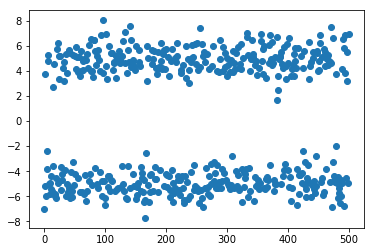

In [500]:
g = GMM_sample(n, m1, s1, m2, s2, w)
import matplotlib.pyplot as plt
plt.scatter(range(n), g)
plt.show()

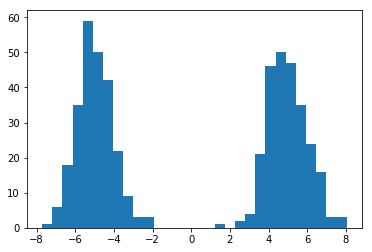

In [501]:
plt.hist(g, bins=30)
plt.show()

In [502]:
from math import pi, sqrt
gaussian = lambda x,m,s: np.exp(-1*0.5*((x-m)/s)**2)/(sqrt(2*pi)*s)

In [503]:
# INITIALIZATION
def init_data(g, n):
    X = g.copy()
    m1, m2 = X[np.random.choice(n, 2, False)]
    prior_1 = np.random.rand()
    s1, s2 = np.std(X), np.std(X)
    prior_2 = 1-prior_1
    Theta = (prior_1, prior_2, m1, m2, s1, s2)
    log_likelihood = []
    return Theta, log_likelihood

In [504]:
Theta, log_likelihood = init_data(g,n)

In [505]:
def expectation(X, Theta):
    prior_1, prior_2, m1, m2, s1, s2 = Theta
    p1_joint = gaussian(X,m1,s1)*prior_1
    p2_joint = gaussian(X,m2,s2)*prior_2
    px = p1_joint+p2_joint
    p1 = p1_joint/px
    p2 = p2_joint/px
    return np.vstack((p1,p2))

In [506]:
def maximization(p, X):
    nsize = X.size
    sum_1 = sum(p[0])
    sum_2 = sum(p[1])
    
    prior_1 = sum_1/nsize
    prior_2 = sum_2/nsize
    
    m1 = round(p[0].dot(X)/sum_1, 5)
    m2 = round(p[1].dot(X)/sum_2, 5)
    
    s1 = round(sqrt(p[0].dot((X-m1)**2)/sum_1), 5)
    s2 = round(sqrt(p[1].dot((X-m2)**2)/sum_2), 5)
    
    return (prior_1, prior_2, m1, m2, s1, s2)

In [507]:
def likelihood(X, Theta):
    prior_1, prior_2, m1, m2, s1, s2 = Theta
    p1_joint = gaussian(X,m1,s1)*prior_1
    p2_joint = gaussian(X,m2,s2)*prior_2
    px = p1_joint+p2_joint
    return sum(np.log(px))

In [508]:
no_processing = lambda x: x

In [509]:
def EM(X, Theta, et, log_likelihood, ix=1, ll=1e3):
    if(abs(ll - likelihood(X, Theta)) < 0.01):
        return log_likelihood
    prior_1, prior_2, m1, m2, s1, s2 = Theta
    print('Iteration-{}:\n Prior_1 => {}\n Prior_2 => {}\n Mean1 => {}\n Mean2 => {}\n Sd1 => {}\n Sd2 => {}'.format(ix,
                                                                                                                     prior_1,
                                                                                                                     prior_2,
                                                                                                                     m1, m2,
                                                                                                                     s1, s2))
    ll = likelihood(X, Theta)
    print('Likelihood => {}'.format(ll))
    print()
    
    log_likelihood.append(ll)
    
    p = expectation(X, Theta)
    Theta = maximization(p, X)
    
    Theta = et(Theta)
    
    return EM(X, Theta, et, log_likelihood, ix+1, ll)

#### <u>EM with no extra information</u>
***

In [510]:
train_ll = EM(X, Theta, no_processing, log_likelihood)

Iteration-1:
 Prior_1 => 0.9315180620836876
 Prior_2 => 0.06848193791631241
 Mean1 => 6.2053
 Mean2 => -3.49134
 Sd1 => 5.079309751137751
 Sd2 => 5.079309751137751
Likelihood => -1819.263776612168

Iteration-2:
 Prior_1 => 0.7461245514446189
 Prior_2 => 0.2538754485553812
 Mean1 => 1.0492
 Mean2 => -4.87804
 Sd1 => 4.95915
 Sd2 => 2.04647
Likelihood => -1433.408180882491

Iteration-3:
 Prior_1 => 0.6663971761553291
 Prior_2 => 0.3336028238446715
 Mean1 => 1.87856
 Mean2 => -5.11822
 Sd1 => 4.72832
 Sd2 => 0.92544
Likelihood => -1313.8721981472843

Iteration-4:
 Prior_1 => 0.566287829400926
 Prior_2 => 0.43371217059907424
 Mean1 => 3.12728
 Mean2 => -5.13365
 Sd1 => 3.98758
 Sd2 => 0.83487
Likelihood => -1261.3496760565483

Iteration-5:
 Prior_1 => 0.5056040895326622
 Prior_2 => 0.4943959104673378
 Mean1 => 4.11573
 Mean2 => -5.13053
 Sd1 => 2.92588
 Sd2 => 0.86344
Likelihood => -1198.221814649487

Iteration-6:
 Prior_1 => 0.4689568366205473
 Prior_2 => 0.5310431633794526
 Mean1 => 4.79

In [511]:
def plt_nll(train_ll):
    train_ll = np.array(train_ll)
    train_ll*=-1
    plt.plot(train_ll)
    plt.ylabel('Neg Log Likelihood')
    plt.xlabel('Iteration')
    plt.show()

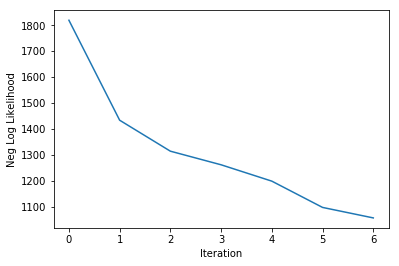

In [512]:
plt_nll(train_ll)

#### <u>EM with true std devn fixed</u>
***

In [513]:
# INITIALIZATION
Theta, log_likelihood = init_data(g,n)

def fix_std(Theta):
    Theta = list(Theta[:-2])
    Theta.extend([1,1])
    return Theta

known_std = lambda x: fix_std(x)
Theta = known_std(Theta)

In [514]:
train_ll = EM(X, Theta, known_std, log_likelihood)

Iteration-1:
 Prior_1 => 0.2755788651378188
 Prior_2 => 0.7244211348621812
 Mean1 => -4.11477
 Mean2 => 4.94196
 Sd1 => 1
 Sd2 => 1
Likelihood => -1253.208693180179

Iteration-2:
 Prior_1 => 0.5440000001269992
 Prior_2 => 0.4559999998730008
 Mean1 => -5.0384
 Mean2 => 5.01164
 Sd1 => 1
 Sd2 => 1
Likelihood => -1057.190906760032



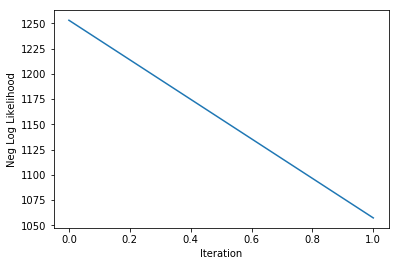

In [515]:
plt_nll(train_ll)

#### <u>EM with true mean fixed</u>
***

In [516]:
# INITIALIZATION
Theta, log_likelihood = init_data(g,n)

def fix_mu(Theta):
    Theta = list(Theta)
    Theta[2:4] = [-5, 5]
    return Theta

known_mu = lambda x: fix_mu(x)
Theta = known_mu(Theta)

In [517]:
train_ll = EM(X, Theta, known_mu, log_likelihood)

Iteration-1:
 Prior_1 => 0.8710209629176179
 Prior_2 => 0.12897903708238212
 Mean1 => -5
 Mean2 => 5
 Sd1 => 5.079309751137751
 Sd2 => 5.079309751137751
Likelihood => -1621.3569607364182

Iteration-2:
 Prior_1 => 0.7565651557716739
 Prior_2 => 0.24343484422832537
 Mean1 => -5
 Mean2 => 5
 Sd1 => 4.60515
 Sd2 => 2.37917
Likelihood => -1460.6883216810504

Iteration-3:
 Prior_1 => 0.6123058732635456
 Prior_2 => 0.3876941267364545
 Mean1 => -5
 Mean2 => 5
 Sd1 => 3.1805
 Sd2 => 1.04407
Likelihood => -1256.8601122475711

Iteration-4:
 Prior_1 => 0.5520901692947988
 Prior_2 => 0.44790983070520085
 Mean1 => -5
 Mean2 => 5
 Sd1 => 1.38872
 Sd2 => 1.02286
Likelihood => -1085.0839216956022

Iteration-5:
 Prior_1 => 0.544000223222966
 Prior_2 => 0.455999776777034
 Mean1 => -5
 Mean2 => 5
 Sd1 => 0.96675
 Sd2 => 1.05124
Likelihood => -1056.526176444366



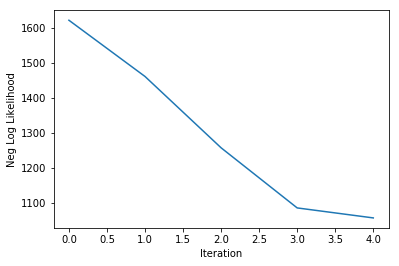

In [518]:
plt_nll(train_ll)

#### <u>EM with spurious mean fixed</u>
***

In [522]:
# INITIALIZATION
Theta, log_likelihood = init_data(g,n)

def fix_wrong_mu(Theta):
    Theta = list(Theta)
    Theta[2:4] = [5, 0]
    return Theta

known_wrong_mu = lambda x: fix_wrong_mu(x)
Theta = known_wrong_mu(Theta)

In [523]:
train_ll = EM(X, Theta, known_wrong_mu, log_likelihood)

Iteration-1:
 Prior_1 => 0.7709075282754854
 Prior_2 => 0.22909247172451463
 Mean1 => 5
 Mean2 => 0
 Sd1 => 5.079309751137751
 Sd2 => 5.079309751137751
Likelihood => -1678.850202262349

Iteration-2:
 Prior_1 => 0.6235145103868197
 Prior_2 => 0.3764854896131808
 Mean1 => 5
 Mean2 => 0
 Sd1 => 4.95846
 Sd2 => 4.01799
Likelihood => -1645.8654317979754

Iteration-3:
 Prior_1 => 0.4894408552442226
 Prior_2 => 0.5105591447557773
 Mean1 => 5
 Mean2 => 0
 Sd1 => 4.76239
 Sd2 => 4.25129
Likelihood => -1604.4702919427139

Iteration-4:
 Prior_1 => 0.3742910967381738
 Prior_2 => 0.6257089032618257
 Mean1 => 5
 Mean2 => 0
 Sd1 => 4.35823
 Sd2 => 4.49413
Likelihood => -1572.4699664756881

Iteration-5:
 Prior_1 => 0.28542057022606476
 Prior_2 => 0.7145794297739351
 Mean1 => 5
 Mean2 => 0
 Sd1 => 3.67334
 Sd2 => 4.64442
Likelihood => -1546.562756130085

Iteration-6:
 Prior_1 => 0.2277499535348105
 Prior_2 => 0.7722500464651901
 Mean1 => 5
 Mean2 => 0
 Sd1 => 2.46721
 Sd2 => 4.71237
Likelihood => -1508

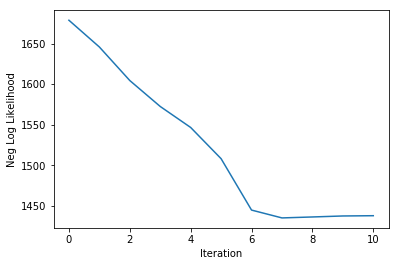

In [524]:
plt_nll(train_ll)